# 5. Feature Selection

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns


############################################ FEATURE SELECTION ############################################
#!pip install scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression # (this is one possible model to apply inside RFE)
from sklearn.linear_model import LogisticRegressionCV # embedded method - LassoCV would be used in a regression problem
from sklearn.tree import DecisionTreeClassifier # embedded method

import warnings
warnings.filterwarnings('ignore')

In [2]:
db = pd.read_excel('db_featureseleccion.xlsx', index_col=None)

In [3]:
db.columns

Index(['idstore', 'sku', 'brand', 'oldpvp', 'labelqty', 'weight (g)',
       'Payment_method', 'Profit (â‚¬)', 'perc_expiring_sku', 'expiring_date',
       'labelling_date', 'sell_date', 'sold', 'type', 'selling_square_ft',
       'district', 'new_pvp', 'discount', 'Margem_num', 'selling_day',
       'selling_day_of_week', 'vida_util_apos_label', 'dias_sell_labelling',
       'labelling_day_of_week', 'labelling_day', 'new_pvp_calculado',
       'diferenca_new_pvp', 'profit_calculado', 'diferenca_profit',
       'dif_sell_labelling_date', 'dif_exp_labelling_date'],
      dtype='object')

## Metodos Filter

## VARIÁVEIS CATEGORICAS


### Chi-Square (Filter Method) - SelectKBest

    

In [4]:
db_chisquare=db
db_chisquare

,idstore,sku,brand,oldpvp,labelqty,weight (g),Payment_method,Profit (â‚¬),perc_expiring_sku,expiring_date,...,vida_util_apos_label,dias_sell_labelling,labelling_day_of_week,labelling_day,new_pvp_calculado,diferenca_new_pvp,profit_calculado,diferenca_profit,dif_sell_labelling_date,dif_exp_labelling_date
0,1,1,marca1,4.22,1,260.0,Card,0.34,0.010050,2021-10-03,...,2,1.0,Friday,1,2.110,0.00,0.34,0.0,1.0,2
1,1,1,marca1,3.96,1,260.0,not_sell,0.32,0.005025,2021-10-02,...,1,NaN,Friday,1,1.980,0.00,0.32,0.0,NaN,1
2,1,1,marca1,4.74,1,260.0,Cash,0.38,0.010050,2021-10-03,...,2,2.0,Friday,1,2.370,0.00,0.38,0.0,2.0,2
3,1,1,marca1,4.20,1,260.0,Card,0.34,0.010050,2021-10-03,...,2,1.0,Friday,1,2.100,0.00,0.34,0.0,1.0,2
4,1,1,marca1,4.62,1,260.0,Cash,0.37,0.010050,2021-10-03,...,2,2.0,Friday,1,2.310,0.00,0.37,0.0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150048,193,318,marca2,2.49,1,97.0,not_sell,0.14,0.100629,2021-10-19,...,16,NaN,Sunday,3,1.245,0.01,0.14,0.0,NaN,16
150049,203,318,marca2,2.49,1,97.0,Cash,0.14,0.113208,2021-10-19,...,18,1.0,Friday,1,1.245,0.01,0.14,0.0,1.0,18
150050,203,318,marca2,2.49,1,97.0,Cash,0.14,0.113208,2021-10-19,...,18,1.0,Friday,1,1.245,0.01,0.14,0.0,1.0,18
150051,139,319,marca24,3.49,1,141.0,Cash,0.46,0.092437,2021-10-17,...,11,5.0,Wednesday,6,2.443,0.00,0.46,0.0,5.0,11


#### Usando Label Encoder

In [5]:
# 1. Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=99, shuffle=True)

# 2. Remove irrelevant columns (same as before)
cols_to_remove = [
    "Payment_method", "Profit (€)", "profit_calculado", "diferenca_profit",
    "dias_sell_labelling", "sell_date", "labelling_date", "expiring_date"
]
# retirei "selling_day_of_week" - Andreia Campos
db_chisquare.drop(columns=cols_to_remove, inplace=True, errors="ignore")

# 3. Select categorical features (same as before)
cat_cols = db_chisquare.select_dtypes(include="object").columns.tolist()
print(cat_cols)

# 4. Encode categorical features using LabelEncoder
db_chisquare_encoded = db_chisquare[cat_cols].copy()
le = LabelEncoder()
for col in cat_cols:
    db_chisquare_encoded[col] = le.fit_transform(db_chisquare_encoded[col].astype(str))

print(db_chisquare_encoded)
# 5. Apply Chi-Square test within StratifiedKFold
X = db_chisquare_encoded
y = db_chisquare["sold"]
alpha=0.05
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(X_train, y_train)  # Fit on training data of the current fold

    # 6. Organize and display results (similar to before)
    chi2_scores = selector.scores_
    chi2_pvalues = selector.pvalues_
    results_db_chisquare = pd.DataFrame({
        "Feature": cat_cols,
        "Chi2 Score": chi2_scores,
        "p-value": chi2_pvalues,
        "Significant (α = 0.05)": chi2_pvalues < alpha
    }).sort_values(by="Chi2 Score", ascending=False)
    print(f"\nResults for Fold {skf.get_n_splits(X, y)}:")  # Indicate the fold number
    print(results_db_chisquare)

['brand', 'type', 'district', 'selling_day_of_week', 'labelling_day_of_week']
        brand  type  district  selling_day_of_week  labelling_day_of_week
0           0     0        17                    2                      0
1           0     0        17                    7                      0
2           0     0        17                    3                      0
3           0     0        17                    2                      0
4           0     0        17                    3                      0
...       ...   ...       ...                  ...                    ...
150048     11     1        16                    7                      3
150049     11     1         6                    2                      0
150050     11     1         6                    2                      0
150051     16     2        10                    1                      6
150052     16     2        10                    7                      6

[150053 rows x 5 columns]

Result

Justificar porque retiramos o 'Payment_method'.

#### Usando Get_dummies

In [6]:
db_chisquare_dummies=db

In [7]:
# 1. Define StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=99, shuffle=True)

# 2. Remove irrelevant columns (same as before)
cols_to_remove = [
    "Payment_method", "Profit (€)", "profit_calculado", "diferenca_profit",
    "dias_sell_labelling", "sell_date", "labelling_date", "expiring_date"
]
# retirei "selling_day_of_week" - Andreia Campos
db_chisquare_dummies.drop(columns=cols_to_remove, inplace=True, errors="ignore")

# 3. Select categorical features (same as before)
cat_cols = db_chisquare_dummies.select_dtypes(include="object").columns.tolist()
print(cat_cols)

# 4. Encode categorical features using LabelEncoder
db_chisquare_dummies_encoded = db_chisquare_dummies[cat_cols].copy()


db_chisquare_dummies_encoded = pd.get_dummies(db_chisquare_dummies[cat_cols], drop_first=False)


# 5. Apply Chi-Square test within StratifiedKFold
X = db_chisquare_dummies_encoded
y = db_chisquare_dummies["sold"]
alpha=0.05
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(X_train, y_train)  # Fit on training data of the current fold

    # 6. Organize and display results (similar to before)
    chi2_scores = selector.scores_
    chi2_pvalues = selector.pvalues_
    results_db_chisquare_dummies = pd.DataFrame({
        "Feature": X_train.columns,
        "Chi2 Score": chi2_scores,
        "p-value": chi2_pvalues,
        "Significant (α = 0.05)": chi2_pvalues < alpha
    }).sort_values(by="Chi2 Score", ascending=False)
    print(f"\nResults for Fold {skf.get_n_splits(X, y)}:")  # Indicate the fold number
    print(results_db_chisquare)

['brand', 'type', 'district', 'selling_day_of_week', 'labelling_day_of_week']

Results for Fold 5:
                 Feature     Chi2 Score   p-value  Significant (α = 0.05)
3    selling_day_of_week  106991.212741  0.000000                    True
0                  brand   21300.037497  0.000000                    True
2               district      14.384727  0.000149                    True
4  labelling_day_of_week       6.656916  0.009877                    True
1                   type       0.053797  0.816584                   False

Results for Fold 5:
                 Feature     Chi2 Score   p-value  Significant (α = 0.05)
3    selling_day_of_week  106991.212741  0.000000                    True
0                  brand   21300.037497  0.000000                    True
2               district      14.384727  0.000149                    True
4  labelling_day_of_week       6.656916  0.009877                    True
1                   type       0.053797  0.816584                 

### Chi-Square (Filter Method) - chi2_contingency


In [8]:
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

In [9]:
db_chisquare_contigency=db

In [10]:
X = db_chisquare_contigency.drop('sold', axis = 1)
y = db_chisquare_contigency['sold'].copy()

In [11]:
X, X_test, y, y_test = train_test_split(X, y,
                                        train_size = 0.9,
                                        random_state = 99,
                                        stratify = y)

In [12]:
def apply_chisquare(X, y, var, alpha=0.05):
    # Tabela de contingência observada
    dfObserved = pd.crosstab(y, X)
    print("=== Tabela Observada ===")
    print(dfObserved)
    print("\n")

    # Teste qui-quadrado
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)

    # Tabela esperada
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index=dfObserved.index)
    print("=== Tabela Esperada ===")
    print(dfExpected)
    print("\n")

    # Estatísticas do teste
    print("=== Estatísticas do Teste Qui-Quadrado ===")
    print(f"Qui-quadrado: {chi2}")
    print(f"p-valor: {p}")
    print(f"Graus de liberdade: {dof}")
    print("\n")

    # Resultado de importância
    if p < alpha:
        result = f"{var} é IMPORTANTE para a predição (p < {alpha})"
    else:
        result = f"{var} NÃO é importante para a predição (Descartar {var})"
    print("=== Resultado ===")
    print(result)
    print("\n")


In [13]:
def select_best_cat_features(X,y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        X_train_cat = X_train[['idstore', 'sku', 'brand', 'type','district',
       'labelling_day_of_week']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)

        count+=1

In [14]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
=== Tabela Observada ===
idstore  1    2    3    4    5    6    7    8    9    10   ...  323  324  325  \
sold                                                       ...                  
False     95  200  133  201  362  168  135  179   79  314  ...   11    2   14   
True     257  314  120  136  488  177  106  297   60  174  ...    0    4    0   

idstore  326  327  328  329  330  331  332  
sold                                        
False      4    7    4    0    1    1    3  
True       6    0    0    3    0    2    0  

[2 rows x 332 columns]


=== Tabela Esperada ===
idstore         1           2           3           4           5    \
sold                                                                  


## VARIÀVEIS NUMÉRICAS

In [15]:
db_chisquare.columns

Index(['idstore', 'sku', 'brand', 'oldpvp', 'labelqty', 'weight (g)',
       'Profit (â‚¬)', 'perc_expiring_sku', 'sold', 'type',
       'selling_square_ft', 'district', 'new_pvp', 'discount', 'Margem_num',
       'selling_day', 'selling_day_of_week', 'vida_util_apos_label',
       'labelling_day_of_week', 'labelling_day', 'new_pvp_calculado',
       'diferenca_new_pvp', 'dif_sell_labelling_date',
       'dif_exp_labelling_date'],
      dtype='object')

In [16]:
db_chisquare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150053 entries, 0 to 150052
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   idstore                  150053 non-null  int64  
 1   sku                      150053 non-null  int64  
 2   brand                    150053 non-null  object 
 3   oldpvp                   150053 non-null  float64
 4   labelqty                 150053 non-null  int64  
 5   weight (g)               150053 non-null  float64
 6   Profit (â‚¬)             150053 non-null  float64
 7   perc_expiring_sku        150053 non-null  float64
 8   sold                     150053 non-null  bool   
 9   type                     150053 non-null  object 
 10  selling_square_ft        150053 non-null  float64
 11  district                 150053 non-null  object 
 12  new_pvp                  150053 non-null  float64
 13  discount                 150053 non-null  float64
 14  Marg

In [17]:
skf2 = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True)

In [18]:
numeric_cols = db.select_dtypes(include='number').columns
db_numeric = db[numeric_cols]
print(numeric_cols)
db_numeric

Index(['idstore', 'sku', 'oldpvp', 'labelqty', 'weight (g)', 'Profit (â‚¬)',
       'perc_expiring_sku', 'selling_square_ft', 'new_pvp', 'discount',
       'Margem_num', 'selling_day', 'vida_util_apos_label', 'labelling_day',
       'new_pvp_calculado', 'diferenca_new_pvp', 'dif_sell_labelling_date',
       'dif_exp_labelling_date'],
      dtype='object')


,idstore,sku,oldpvp,labelqty,weight (g),Profit (â‚¬),perc_expiring_sku,selling_square_ft,new_pvp,discount,Margem_num,selling_day,vida_util_apos_label,labelling_day,new_pvp_calculado,diferenca_new_pvp,dif_sell_labelling_date,dif_exp_labelling_date
0,1,1,4.22,1,260.0,0.34,0.010050,4762.0,2.11,0.5,0.16,2.0,2,1,2.110,0.00,1.0,2
1,1,1,3.96,1,260.0,0.32,0.005025,4762.0,1.98,0.5,0.16,NaN,1,1,1.980,0.00,NaN,1
2,1,1,4.74,1,260.0,0.38,0.010050,4762.0,2.37,0.5,0.16,3.0,2,1,2.370,0.00,2.0,2
3,1,1,4.20,1,260.0,0.34,0.010050,4762.0,2.10,0.5,0.16,2.0,2,1,2.100,0.00,1.0,2
4,1,1,4.62,1,260.0,0.37,0.010050,4762.0,2.31,0.5,0.16,3.0,2,1,2.310,0.00,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150048,193,318,2.49,1,97.0,0.14,0.100629,5048.0,1.24,0.5,0.11,NaN,16,3,1.245,0.01,NaN,16
150049,203,318,2.49,1,97.0,0.14,0.113208,9370.0,1.24,0.5,0.11,2.0,18,1,1.245,0.01,1.0,18
150050,203,318,2.49,1,97.0,0.14,0.113208,9370.0,1.24,0.5,0.11,2.0,18,1,1.245,0.01,1.0,18
150051,139,319,3.49,1,141.0,0.46,0.092437,1061.0,2.44,0.3,0.19,11.0,11,6,2.443,0.00,5.0,11


### Variância

In [19]:
X2 = db_numeric.drop(['idstore', 'sku', 'new_pvp_calculado', 'diferenca_new_pvp', 'dif_sell_labelling_date',
       'dif_exp_labelling_date', 'selling_day'], axis = 1)
y2 = db['sold'].copy()

In [20]:
X2, X2_test, y2, y2_test = train_test_split(X2, y2,
                                        train_size = 0.9,
                                        random_state = 99,
                                        stratify = y2)

In [21]:
def apply_variance(X2_train):
    print(X2_train.var(numeric_only=True).apply(lambda x2: f"{x2:.5f}"))

In [22]:
def select_features_variance(X2,y2):
    count = 1
    for train_index, val_index in skf.split(X2,y2):
        X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]
        y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        apply_variance(X2_train)

        count+=1

In [23]:
select_features_variance(X2,y2)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
oldpvp                         0.32103
labelqty                       0.00000
weight (g)                  3302.10071
Profit (â‚¬)                   0.00580
perc_expiring_sku              0.04957
selling_square_ft       29704860.63036
new_pvp                        0.15476
discount                       0.00135
Margem_num                     0.00109
vida_util_apos_label           1.71003
labelling_day                 73.96949
dtype: object
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
o

A variavél labelqty é constante, então iremos remove-la.

In [24]:
X2 = X2.drop(['labelqty'], axis = 1)

In [25]:
X2.columns

Index(['oldpvp', 'weight (g)', 'Profit (â‚¬)', 'perc_expiring_sku',
       'selling_square_ft', 'new_pvp', 'discount', 'Margem_num',
       'vida_util_apos_label', 'labelling_day'],
      dtype='object')

In [26]:
X3=X2
y3=y2

### Spearman

In [27]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [28]:
def apply_correlation(X2_train):
    correlation_data = X2_train.copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only=True)

    threshold = 0.7
    correlated_pairs = []

    for i in range(len(matrix.columns)):
        for j in range(i + 1, len(matrix.columns)):
            corr_value = matrix.iloc[i, j]
            if abs(corr_value) >= threshold:
                correlated_pairs.append({
                    'Feature 1': matrix.columns[i],
                    'Feature 2': matrix.columns[j],
                    'Correlation': corr_value
                })

    # Converter em DataFrame para melhor visualização
    correlated_df = pd.DataFrame(correlated_pairs)
    
    if not correlated_df.empty:
        print("\nPares de features com correlação (|ρ| ≥ 0.7):")
        print(correlated_df.sort_values(by='Correlation', ascending=False))
    else:
        print("\nNenhum par de features com correlação ≥ 0.7 foi encontrado.")
        
    cor_heatmap(matrix)

In [29]:
def redundant_features(X2,y2):
    count = 1
    for train_index, val_index in skf.split(X2,y2):
        X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]
        y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using spearman correlation
        apply_correlation(X2_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

Pares de features com correlação (|ρ| ≥ 0.7):
           Feature 1             Feature 2  Correlation
1             oldpvp               new_pvp     0.992499
3  perc_expiring_sku  vida_util_apos_label     0.819099
2       Profit (â‚¬)               new_pvp     0.790278
0             oldpvp          Profit (â‚¬)     0.780882


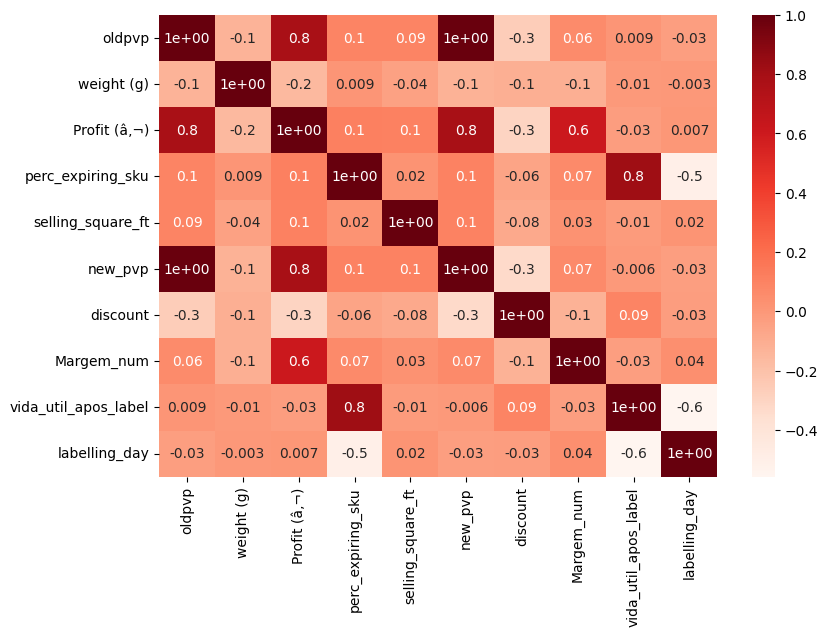

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

Pares de features com correlação (|ρ| ≥ 0.7):
           Feature 1             Feature 2  Correlation
1             oldpvp               new_pvp     0.992332
3  perc_expiring_sku  vida_util_apos_label     0.817399
2       Profit (â‚¬)               new_pvp     0.790166
0             oldpvp          Profit (â‚¬)     0.780593


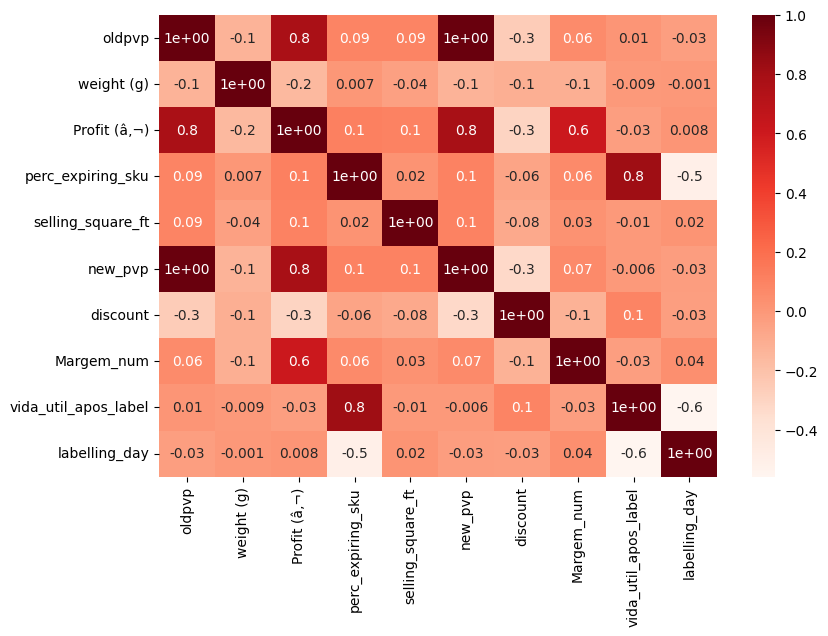

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

Pares de features com correlação (|ρ| ≥ 0.7):
           Feature 1             Feature 2  Correlation
1             oldpvp               new_pvp     0.992379
3  perc_expiring_sku  vida_util_apos_label     0.816325
2       Profit (â‚¬)               new_pvp     0.788773
0             oldpvp          Profit (â‚¬)     0.779191


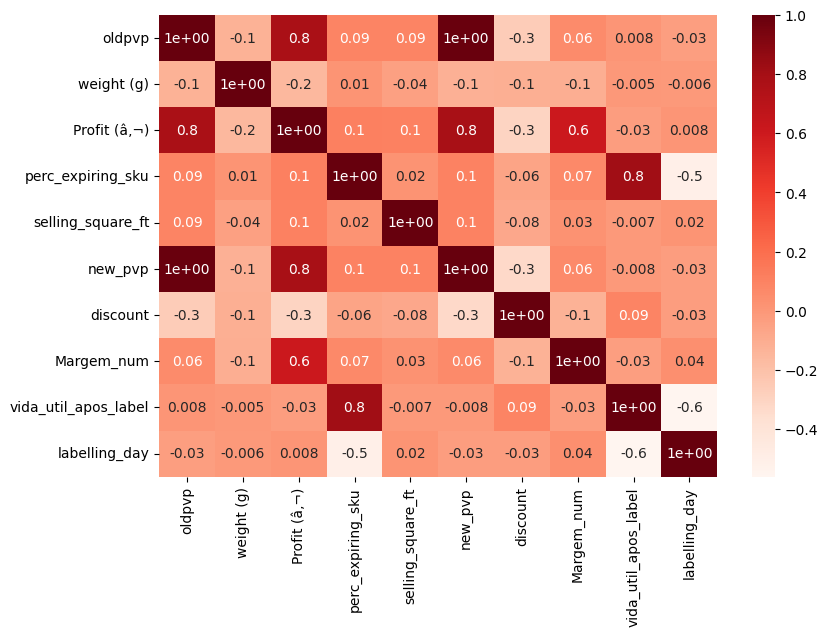

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

Pares de features com correlação (|ρ| ≥ 0.7):
           Feature 1             Feature 2  Correlation
1             oldpvp               new_pvp     0.992377
3  perc_expiring_sku  vida_util_apos_label     0.816937
2       Profit (â‚¬)               new_pvp     0.789583
0             oldpvp          Profit (â‚¬)     0.780039


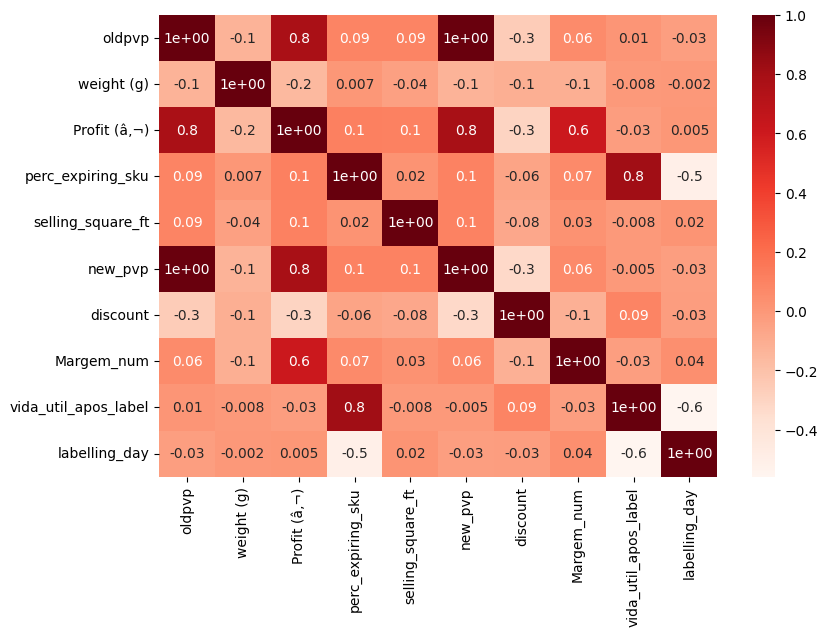

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

Pares de features com correlação (|ρ| ≥ 0.7):
           Feature 1             Feature 2  Correlation
1             oldpvp               new_pvp     0.992164
3  perc_expiring_sku  vida_util_apos_label     0.814164
2       Profit (â‚¬)               new_pvp     0.790354
0             oldpvp          Profit (â‚¬)     0.780767


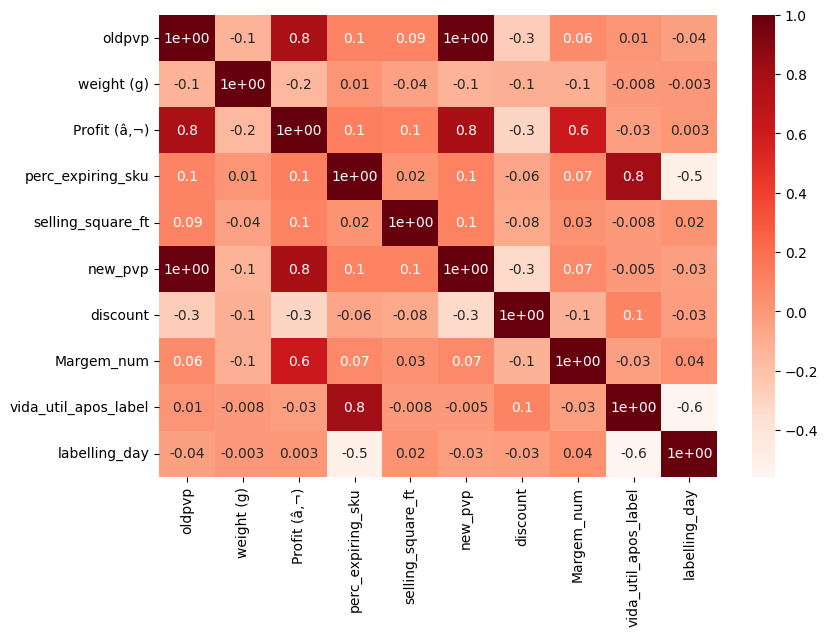

In [30]:
redundant_features(X2, y2)

In [31]:
#Excluir variaveis com correlação >= |0.8|
X2 = X2.drop(['oldpvp','vida_util_apos_label'], axis = 1)

### Métodos Embedded - Arvore de Decisão


In [32]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [33]:
def apply_dt(X2_train, y2_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X2_train, y2_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X2_train.columns)
    plot_importance(feature_importances, 'DT')

In [34]:
def select_best_features_dt(X2, y2):
    count = 1
    for train_index, val_index in skf.split(X2,y2):
        X2_train, X2_val = X2.iloc[train_index], X2.iloc[val_index]
        y2_train, y2_val = y2.iloc[train_index], y2.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        apply_dt(X2_train, y2_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


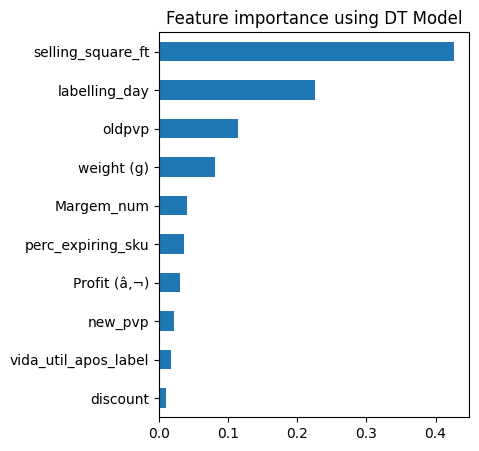

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


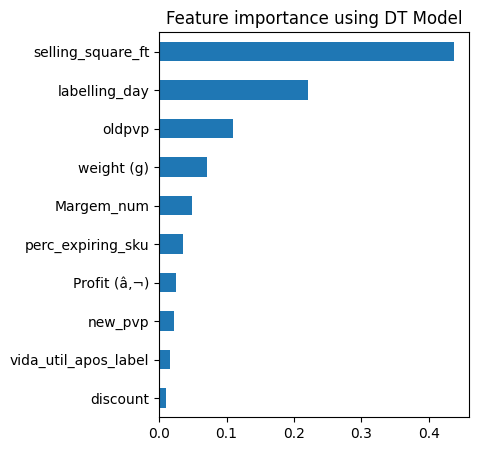

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


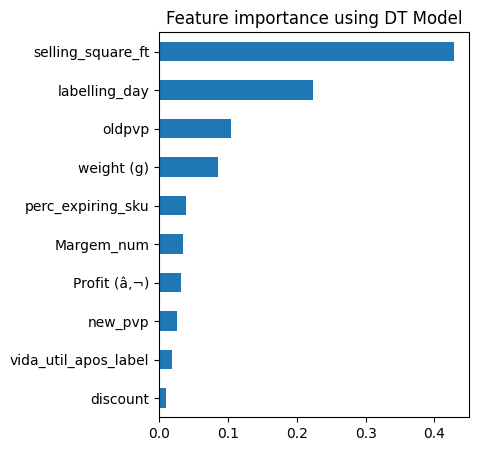

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


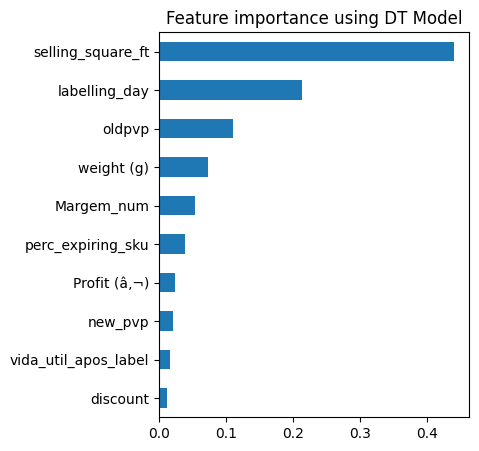

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


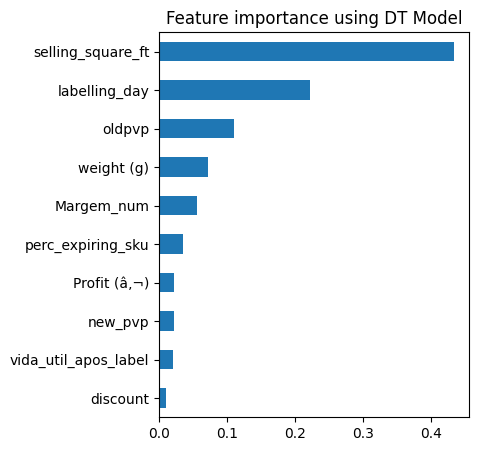

In [35]:
select_best_features_dt(X3, y3)

Com base na correlação de spearman e na arvore de decisão, iremos remover as seguintes variáveis: 'new_pvp','vida_util_apos_label', 'discount', 'Profit (â‚¬'

In [36]:
db_numeric = db_numeric.drop(['new_pvp','vida_util_apos_label', 'discount', 'Profit (â‚¬)'], axis = 1)

Neste momento, já removemos as variáveis correlacionadas e podemos aplicar técnicas que utilizam regressão.

Para aplicar Lasso Regression e RFE (usando Regressão Logística como estimador), é necessário escalar os dados previamente.

No caso das Árvores de Decisão, isso não é necessário – os resultados devem ser semelhantes com ou sem os dados escalados.

### Metódos Wrapper -  Recursive Feature Elimination (RFE)

In [37]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

### Métodos Embedded - Lasso

In [38]:
db_numeric.columns

Index(['idstore', 'sku', 'oldpvp', 'labelqty', 'weight (g)',
       'perc_expiring_sku', 'selling_square_ft', 'Margem_num', 'selling_day',
       'labelling_day', 'new_pvp_calculado', 'diferenca_new_pvp',
       'dif_sell_labelling_date', 'dif_exp_labelling_date'],
      dtype='object')

In [39]:
X4=db_numeric.drop(['idstore', 'sku', 'new_pvp_calculado', 'diferenca_new_pvp', 'dif_sell_labelling_date',
       'dif_exp_labelling_date', 'selling_day'], axis = 1)
y4=db['sold']

In [40]:
def apply_lasso(X_train, y_train):
    lasso = LogisticRegressionCV(penalty='l1', solver='saga').fit(X_train, y_train)
    coef = pd.Series(abs(lasso.coef_[0]), index = X_train.columns)
    plot_importance(coef,'Lasso')

In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        ########################################### SCALE DATA #################################################### 
        scaler = MinMaxScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index=X_train.index)
    
        ######################################### SELECT FEATURES #################################################        
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)
            
        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp                True
labelqty             False
weight (g)            True
perc_expiring_sku     True
selling_square_ft     True
Margem_num           False
labelling_day         True
dtype: bool

----------------- LASSO ----------------------


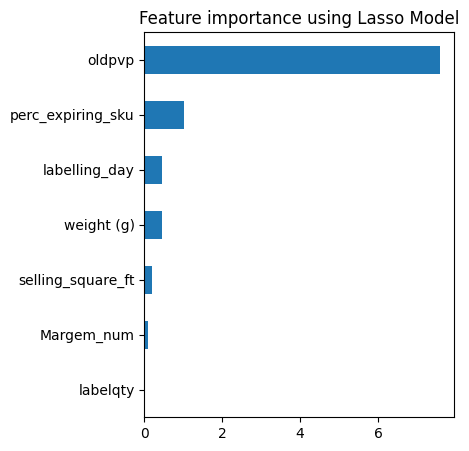


----------------- DT ----------------------


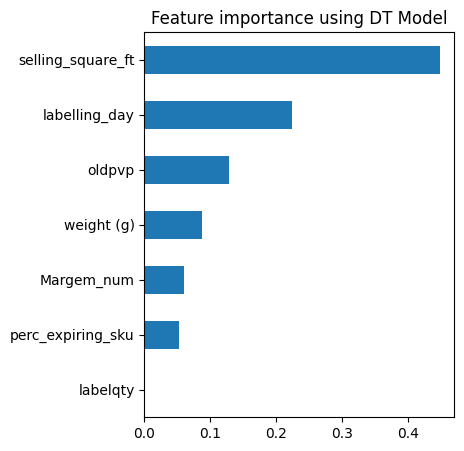

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp                True
labelqty             False
weight (g)            True
perc_expiring_sku     True
selling_square_ft     True
Margem_num           False
labelling_day         True
dtype: bool

----------------- LASSO ----------------------


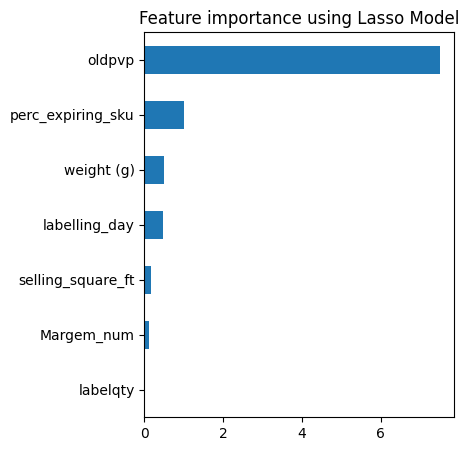


----------------- DT ----------------------


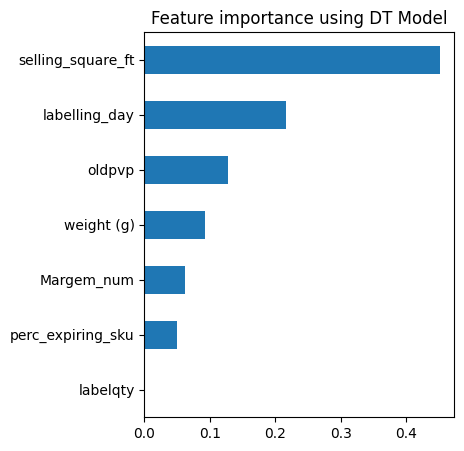

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp                True
labelqty             False
weight (g)            True
perc_expiring_sku     True
selling_square_ft     True
Margem_num           False
labelling_day         True
dtype: bool

----------------- LASSO ----------------------


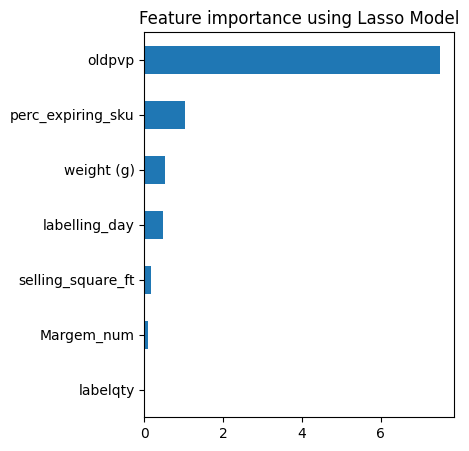


----------------- DT ----------------------


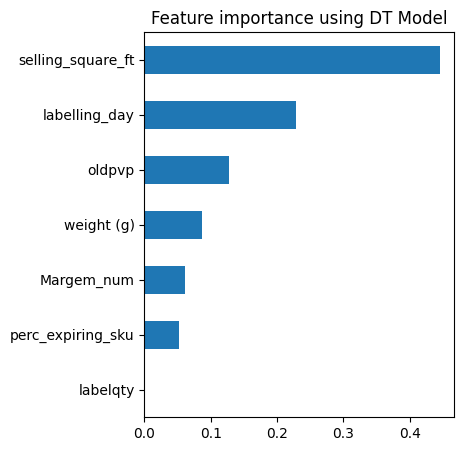

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp                True
labelqty             False
weight (g)            True
perc_expiring_sku     True
selling_square_ft     True
Margem_num           False
labelling_day         True
dtype: bool

----------------- LASSO ----------------------


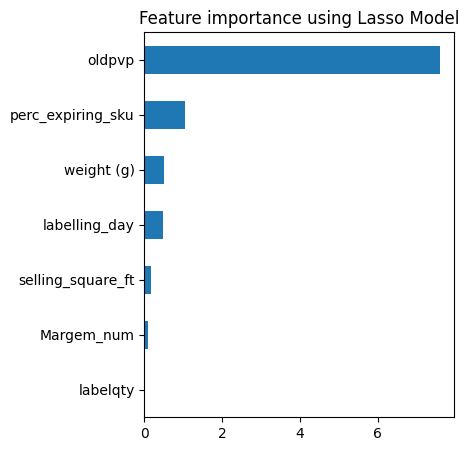


----------------- DT ----------------------


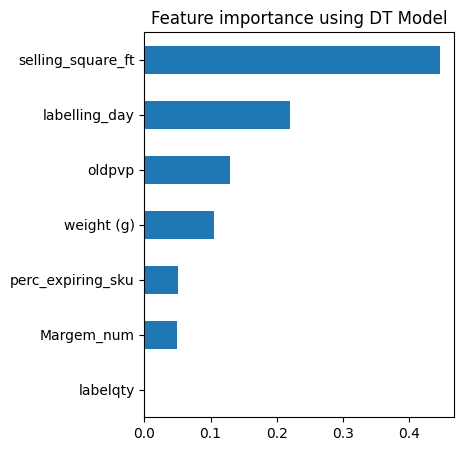

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp                True
labelqty             False
weight (g)            True
perc_expiring_sku     True
selling_square_ft     True
Margem_num           False
labelling_day         True
dtype: bool

----------------- LASSO ----------------------


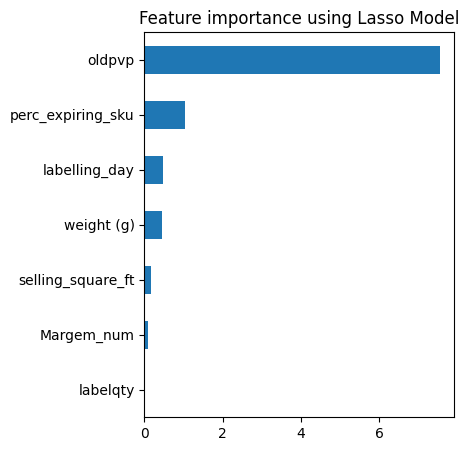


----------------- DT ----------------------


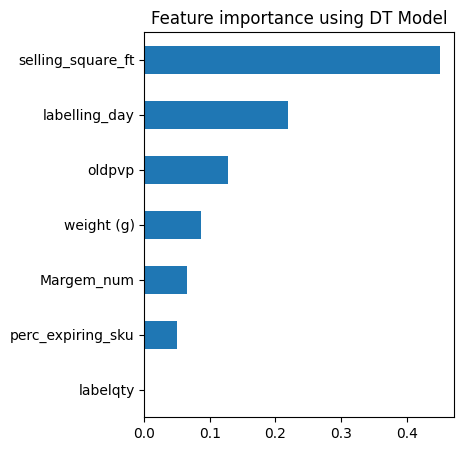

In [43]:
select_best_features(X4, y4)

### Resumo

| Predictor | RFE | Lasso | DT | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- | --- |
Selling_square_ft      | 5 YES | 5 YES | 5 YES | KEEP |
labelling_day             | 5 YES | 5 YES | 5 YES | KEEP |
oldpvp             | 5 YES | 5 YES | 5 YES | KEEP |
weight (g)         | 5 YES | 5 YES | 5 YES | KEEP |
Margem_num         | 0 YES | 5 YES | 5 YES | TRY WITH AND WITHOUT |
perc_expiring_sku | 5 YES | 5 YES | 5 YES | KEEP |
labelqty    | 0 YES | 0 YES | 0 YES | REMOVE |


In [44]:
db.columns

Index(['idstore', 'sku', 'brand', 'oldpvp', 'labelqty', 'weight (g)',
       'Profit (â‚¬)', 'perc_expiring_sku', 'sold', 'type',
       'selling_square_ft', 'district', 'new_pvp', 'discount', 'Margem_num',
       'selling_day', 'selling_day_of_week', 'vida_util_apos_label',
       'labelling_day_of_week', 'labelling_day', 'new_pvp_calculado',
       'diferenca_new_pvp', 'dif_sell_labelling_date',
       'dif_exp_labelling_date'],
      dtype='object')

In [45]:
keep_data = db[['selling_square_ft','labelling_day','oldpvp','weight (g)','perc_expiring_sku', 'brand', 'type', 'district', 'selling_day_of_week', 'labelling_day_of_week']].copy()
all_data =  db[['selling_square_ft','labelling_day','oldpvp','weight (g)','perc_expiring_sku', 'Margem_num', 'brand', 'type', 'district', 'selling_day_of_week', 'labelling_day_of_week']].copy()

# 6. Model